In [4]:
pip install scipy

In [ ]:
# %matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import os
import numpy as np
from numpy import sqrt
from lmfit import  Model, Parameters
from numpy import pi
from scipy.optimize import curve_fit
import csv
# import scipy
# from scipy import integrate

In [4]:

def UCkinetics(x, b, a):
    return a * x * (1 + (1 - sqrt(1 + (2 * b * x))/(b * x)))

def UCkinetics2(x, b, a):
    # print(a * 10**x * (1 + (1 - sqrt(1 + (2 * b * 10**x))/(b * 10**x))))
    return np.log10(a * 10**x * (1 + (1 - sqrt(1 + (2 * b * 10**x))/(b * 10**x))))
def line1(x, a, b):
    return a*x + b
def line2(x, c, d):
    return c*(x**2) + d


In [11]:
plt.close()
data = UCkinetics2(2, 200, 10000)
print('l')
print(data)
BeamRadius = 314 #um
Beam_angle = 45
BeamArea = ((int(BeamRadius)/10000) / (np.sin((int(Beam_angle))*np.pi/180))) * (int(BeamRadius)/10000) * np.pi
print(BeamArea)

l
6.298853049130072
0.004380504861706621


1547.9949309479045
Total Samples: [44172.99058186947, 36525.47024857424, 34585.05464161873, 28604.008888414697, 21819.402789742035, 16854.221677826477, 13749.556706697664, 11334.309986510692, 7257.1543700135935, 3784.9518545085057, 3015.6341373979103, 2972.2601414777287, 1024.5394404725073, 857.4354140852802, 550.8497481863103, 321.1958539983997, 254.08030241664454, 97.22623611792355, 84.05423840953146, 53.53264233306662, 29.494317225723698, 23.21650202675]


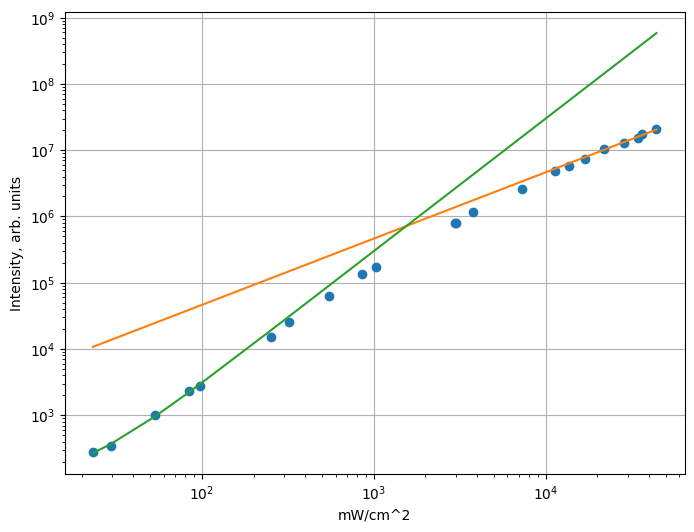

In [15]:
path = r'C:\Users\Manvydas\Desktop\FTMC\Duomenys'
dates = '20230524_DPA1E-2MPtOEP1E-5M UCQY PLQY\\unfocused\\threshold'
comment = ''
quadratic_fit_upper_limit = 100
quadratic_fit_lower_limit = 0.01
Integrate_from = 370
Integrate_to = 520
Power_multiplier = 1
measured_beam_radius = 350 #um



solve1 = []
solve2 = []
# pathfullsphere = path + '\\' + dates + '\\' + 'sfera'
# pathfullspectra = path + '\\' + dates + '\\' + 'spektrai'
plt.close()
fig = plt.figure(figsize = (8, 6))
filenames = os.listdir(path + "\\" + dates)
filename = [f for f in filenames if ".txp" in f]
names = [os.path.join(path + "\\" + dates, basename) for basename in filename]
names.sort(key=lambda x: os.path.getmtime(x))
powers = []
Intensities = []
for f in names:
    df = pd.read_csv(f, sep='\t')
    df.columns = ['WL', 'SAMPLE']
    
    Exposure = float(f.split('_')[-9].replace('ms',''))
    df['SAMPLE'] = df['SAMPLE']/(Exposure/1000)
    dfw = df.copy()
    dfw = dfw[dfw['WL'] < Integrate_to]
    dfw = dfw[dfw['WL'] > Integrate_from]
    # dfw['SAMPLE'].apply
    Intensity = float(np.trapz([dfw['SAMPLE']]))
    if 'NC' in f:
        Intensity = Intensity*80
    Intensities.append(Intensity)
    Power = (float(f.split('_')[-6].replace('W',''))*1000)/0.004380504861706621
    #Power = (float(f.split('_')[-6].replace('W',''))*1000)/(((measured_beam_radius/10000*measured_beam_radius*1.4/10000))*pi)
    # Power = (float(f.split('_')[-2].replace('W',''))*1000)/(((measured_beam_radius/10000)**2)*pi)
    Power = Power * Power_multiplier
    powers.append(Power)
    plt.yscale('log')

#     # WRITE CSV
test_list  = [powers, Intensities]
dfx = pd.DataFrame(test_list, index=['powers', 'intensities']).T
csvname = os.path.join(path + "\\" + dates)
dfx.to_csv(csvname + "\\data.csv", index=None)


dfx = pd.DataFrame(test_list, index=['powers', 'intensities']).T
dfy = dfx.copy()
dfy = dfy[dfy['powers'] < quadratic_fit_upper_limit]
dfy = dfy[dfy['powers'] > quadratic_fit_lower_limit]
dfy = dfy[dfy['intensities'] > 0]
params1 = Parameters()
params2 = Parameters()
params1.add("a", value=32000, min = -1000, max = 1E12)
params1.add("b", value=1, min = -1E12, max = 1E12)
params2.add("c", value=300)
params2.add("d", value=1)

gmod1 = Model(line1)
gmod2 = Model(line2)
Intensitiesarr = np.asarray(dfy['intensities'])
Intensitiesarr[Intensitiesarr<0] = 1E-15
# weights=np.sqrt(1.0/Intensitiesarr)
weights=1/Intensitiesarr
result1 = gmod1.fit(Intensities, x=powers, params = params1)
result2 = gmod2.fit(dfy['intensities'], x=dfy['powers'], params = params2, weights=weights)

labels = f.split('_')[-2] + '_' + f.split('_')[-1] 
plt.plot(powers, Intensities, 'o', label = labels)
plt.plot(powers, result1.best_fit)

dfx['squarefit'] = line2(dfx['powers'],  result2.params['c'].value, result2.params['d'].value)
# plt.plot(dfy['powers'], result2.init_fit, 'b--')
plt.plot(dfx['powers'], dfx['squarefit'])

a = result1.params['a'].value
b = result1.params['b'].value
c = result2.params['c'].value
d = result2.params['d'].value
solve1 = (a-sqrt(a**2+4*b*c-4*c*d))/(2*c)
solve2 = (sqrt(a**2+4*b*c-4*c*d)+a)/(2*c)
print(solve2)
# theta = np.polyfit(powers, Intensities, 1)

# pw, cov = curve_fit(UCkinetics, dfx.x, dfy.y, p0 = (10000, 200))




plt.yscale('log'); plt.xscale('log'); 
plt.grid(); plt.xlabel('mW/cm^2'); plt.ylabel('Intensity, arb. units')
print('Total Samples:', powers)
plt.show()

# THIS SECTION WRITES USER PARAMETERS FILE
now = datetime.datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
headerList = ['Time', 'Measured beam radius, um', 'Lower bound for quadratic fit, mW', 'Upper bound for quadratic fit, mW', 'Integration lower range, nm', 'Integration upper range', 'Power Multiplier', 'intercept', 'comment']
parameters_list  = [now, measured_beam_radius, quadratic_fit_lower_limit, quadratic_fit_upper_limit, Integrate_from, Integrate_to, Power_multiplier, solve2, comment]
csvname = os.path.join(path + "\\" + dates + "\\" + 'Fitting parameters.csv')
if not os.path.exists(csvname):
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=',')
        resultwriter.writerow(headerList)
        resultwriter.writerow(parameters_list)
else:
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=',')
        resultwriter.writerow(parameters_list)

OverflowError: (34, 'Result too large')

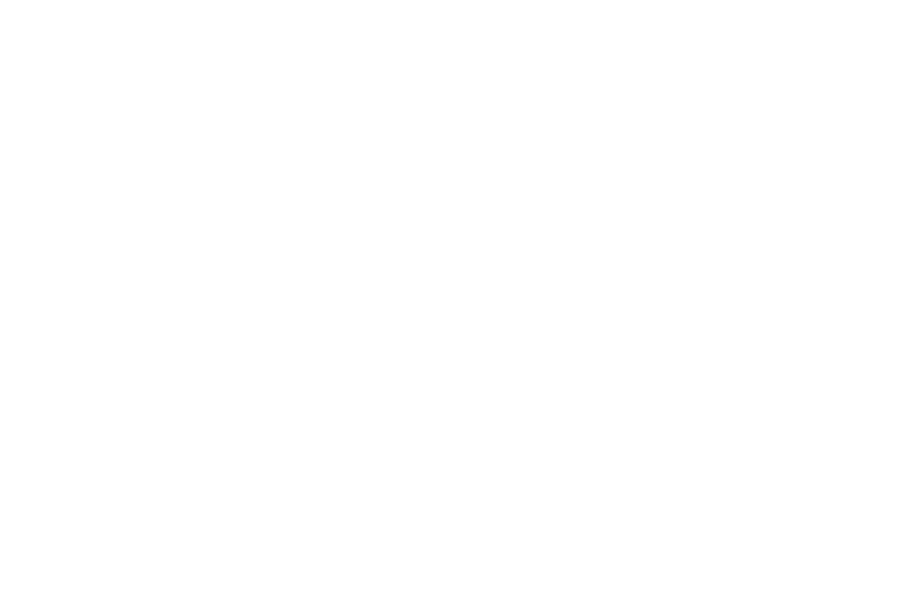

In [10]:
plt.close()
lower = 1
upper = 4.5
length = 100
ylist = []
fig7 = plt.figure(figsize = (9,6))
fakex = [lower + x*(upper-lower)/length for x in range(length)]
for i in fakex:
    y = UCkinetics2(i, b = 0.2, a = 407.5 )
    ylist.append(y)
plt.plot(fakex, ylist, 'x')
plt.plot(powers, Intensities, 'o')
# plt.yscale('log'); plt.xscale('log'); 
plt.grid(); plt.xlabel('mW/cm^2'); plt.ylabel('Intensity, arb. units')
plt.show()

In [14]:

f = (((measured_beam_radius/10000*measured_beam_radius*1.4/10000))*pi)
print(f)

0.014390303910809721
